In [22]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils
pwd = %pwd

from pyspark import SparkContext
sc=SparkContext()

import os

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [2]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[a.strip() for a in feature_text.split(',')]
print(len(features),features)

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [13]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it
data_folder = '../../Data/HIGGS'
from os.path import exists
if not exists(data_folder):
    print("creating directory HIGGS")
    !mkdir -p {data_folder}/HIGGS
%cd {data_folder}
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print('downloading HIGGS.csv.gz')
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print('decompressing HIGGS.csv.gz --- May take 5-10 minutes')
    !gunzip -f HIGGS.csv.gz
!ls -l

/home/jovyan/work/CSE255-DSE230-2018/Sections/Data/HIGGS
total 7847172
-rw-r--r-- 1 jovyan users 8035497980 May 12 20:18 HIGGS.csv


In [14]:
# Have a look at the first two lines of the data file
!head -2 HIGGS.csv

1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
1.000000000000000000e+00,9.075421094894409180e-01,3.291472792625427246e-01,3.594118654727935791e-01,1.497969865798950195e+00,-3.130095303058624268e-01,1.095530629158020020e+00,-5.575249195098876953e-01,-1.588229775428771973e+00,2.173076152801513672e+00,8.12581181526

In [25]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
current_path = %pwd
inputRDD=sc.textFile(os.path.join(current_path, "HIGGS.csv"))
inputRDD.first()

'1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01'

### Reducing data size
Make the dataset smaller to be able to run the computations on your local machine

In [26]:
input_sampled = inputRDD.sample(False,0.01)

# Transform the text RDD into an RDD of LabeledPoints
def LineToLabeledPoint(line):
    V = [float(x) for x in line.split(',')]
    return LabeledPoint(V[0],V[1:])
Data=input_sampled.map(LineToLabeledPoint)
Data.first()

LabeledPoint(1.0, [1.3436527252197266,0.8385329246520996,-1.0611385107040405,2.472015142440796,-0.5726317167282104,1.5127099752426147,1.1436901092529297,0.8555619716644287,0.0,0.88422030210495,1.4746055603027344,-1.36064875125885,1.1074360609054565,1.5872656106948853,2.2348334789276123,0.07756848633289337,0.0,1.6094081401824951,2.39640474319458,0.7572935223579407,0.0,0.9340201020240784,0.8447072505950928,1.0778440237045288,1.4001836776733398,0.9477745294570923,1.007614254951477,0.9010174870491028])

### 70-30 split into train/test

In [ ]:
from time import time
start = time()
(trainingData,testData)=Data.randomSplit([0.7,0.3])

print('Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data.count(),trainingData.cache().count(),testData.cache().count()))
print("Sampling and splitting took:", int(time()-start),'seconds')

In [8]:
# Checking testData distribution
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(1.0, 17495), (0.0, 15359)]

### Random forests


In [9]:
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=10, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=depth, maxBins=32)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in list(dataSets.keys()):  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda v_p:v_p[0] != v_p[1]).count()/float(data.count())
        errors[depth][name]=Err
    print(depth,errors[depth],int(time()-start),'seconds')
print(errors)

1 {'test': 0.40375601144457296, 'train': 0.40663722002892544} 31 seconds
3 {'test': 0.34741583977597856, 'train': 0.345594079401686} 32 seconds
6 {'test': 0.32367443842454496, 'train': 0.316955269775502} 43 seconds
10 {'test': 0.30452912887319655, 'train': 0.2664008651578522} 86 seconds
15 {'test': 0.30745114750106534, 'train': 0.13678354115363067} 316 seconds
20 {'test': 0.3139952517197297, 'train': 0.03345971934487746} 818 seconds
{1: {'test': 0.40375601144457296, 'train': 0.40663722002892544}, 3: {'test': 0.34741583977597856, 'train': 0.345594079401686}, 6: {'test': 0.32367443842454496, 'train': 0.316955269775502}, 10: {'test': 0.30452912887319655, 'train': 0.2664008651578522}, 15: {'test': 0.30745114750106534, 'train': 0.13678354115363067}, 20: {'test': 0.3139952517197297, 'train': 0.03345971934487746}}


In [ ]:
%pylab inline

In [10]:
def extract_errors(B):
    keys=B.keys()
    keys.sort()
    train=[]; test=[];
    for key in keys:
        train.append(B[key]['train'])
        test.append(B[key]['test'])
    return keys,train,test

In [17]:
## For 30 trees
rf_30 = {1: {'test': 0.4015156126361921, 'train': 0.4040561016356502},
3: {'test': 0.3712642278897072, 'train': 0.3742051620757087},
6:{'test': 0.31812648365694807, 'train': 0.3096338889104731},
10: {'test': 0.30120518595167084, 'train': 0.25696414002097984}}

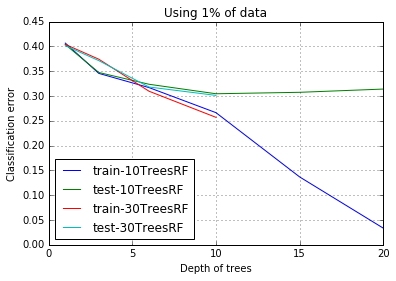

In [21]:
keys,train,test = extract_errors(errors)
st='10TreesRF'
plot(keys,train,label='train-'+st)
plot(keys,test,label='test-'+st)
keys,train,test = extract_errors(rf_30)
st='30TreesRF'
plot(keys,train,label='train-'+st)
plot(keys,test,label='test-'+st)
title('Using 1% of data')
grid()
xlabel("Depth of trees")
ylabel("Classification error")
legend(loc = "lower left")

### Gradient Boosting

In [ ]:
from time import time
errors={}
for depth in [1,3,6,10,20]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo={},numIterations=10,maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in list(dataSets.keys()):  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda v_p:v_p[0] != v_p[1]).count()/float(data.count())
        errors[depth][name]=Err
    print(depth,errors[depth],int(time()-start),'seconds')
print(errors)

1 {'test': 0.38162780787727524, 'train': 0.3814642536059102} 52 seconds
3 {'test': 0.32434406769343155, 'train': 0.31963934383509884} 66 seconds
6 {'test': 0.3016071102453278, 'train': 0.2899972638079975} 104 seconds
10

In [ ]:
def extract_errors(B):
    keys=B.keys()
    keys.sort()
    train=[]; test=[];
    for key in keys:
        train.append(B[key]['train'])
        test.append(B[key]['test'])
    return keys,train,test

In [ ]:
keys,train,test = extract_errors(B10)
plot(keys,train,label='train-10Boost')
plot(keys,test,label='test-10Boost')
keys,train,test = extract_errors(B100)
plot(keys,train,label='train-100Boost')
plot(keys,test,label='test-100Boost')
title('Using 1% of data')
grid()
xlabel("Depth of trees")
ylabel("Classification error")
legend()